In [ ]:
# -*- coding: utf-8 -*-
#@markdown <font color='Gren'>Initialization of Libs and Dependency</font>
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
!pip install Pillow
!pip install -q piglet pyvirtualdisplay
!pip install -q pyvista
!apt-get -qq install xvfb
from pyvirtualdisplay import Display
display = Display(visible=0, size=(600, 400))
display.start()
import math
import numpy as np
import numpy
import pyvista
import scipy.ndimage
import scipy.misc
from scipy import ndimage
import argparse
import torch
import torchvision
from PIL import Image
import torchvision.transforms.functional as F

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.5/67.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 MB 10.6 MB/s eta 0:00:00
Selecting previously unselected package libfontenc1:amd64.
(Reading database ... 122519 files and directories currently installed.)
Preparing to unpack .../0-libfontenc1_1%3a1.1.4-0ubuntu1_amd64.deb ...
Unpacking libfontenc1:amd64 (1:1.1.4-0ubuntu1) ...
Selecting previously unselected package libxfont2:amd64.
Preparing to unpack .../1-libxfont2_1%3a2.0.3-1_amd64.deb ...
Unpacking libxfont2:amd64 (1:2.0.3-1) ...
Selecting previously unselected package libxkbfile1:amd64.
Preparing to unpack .../2-libxkbfile1_1%3a1.1.0-1_amd64.deb ...
Unpacking libxkbfile1:amd64 (1:1.1.0-1) ...
Selecting previously unselected package x11-xkb-utils.
Preparing to unpack .../

In [ ]:
# import cv2
# -*- coding: utf-8 -*-
#@markdown <font color='Gren'>Pre-Process Step</font>

path_to_img = "mars.jpg"
img = cv2.imread(path_to_img)
img_h, img_w, _ = img.shape
split_width = 900
split_height = 900


def start_points(size, split_size, overlap=30):
    points = [0]
    stride = int(split_size * (1-overlap))
    counter = 1
    while True:
        pt = stride * counter
        if pt + split_size >= size:
            points.append(size - split_size)
            break
        else:
            points.append(pt)
        counter += 1
    return points


X_points = start_points(img_w, split_width, 0.5)
Y_points = start_points(img_h, split_height, 0.5)

count = 0
name = 'overlap'
frmt = 'jpg'

for i in Y_points:
    for j in X_points:
        split = img[i:i+split_height, j:j+split_width]
        cv2.imwrite('{}_{}.{}'.format(name, count, frmt), split)
        count += 1
!rm 'mars.jpg'

height:  617  width:  546
(x1,y1): (10,12) , (x2,y2): (536,605)


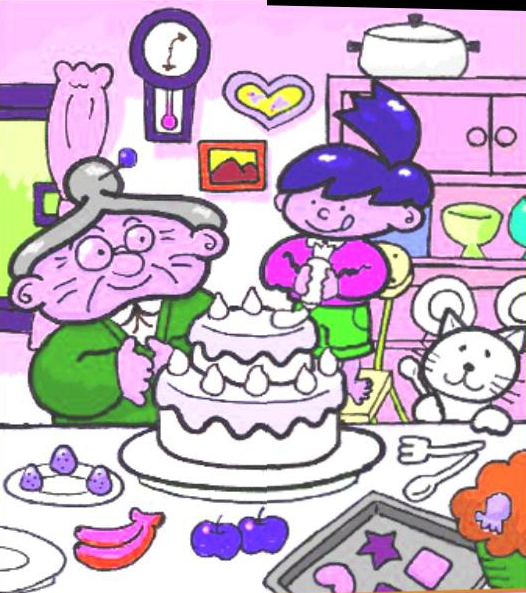

(526, 593)


In [ ]:
# -*- coding: utf-8 -*-
#@markdown <font color='Gren'> Please input the file extension for the images used. (eg: .png, .jpg) </font>
file_extension = '*.jpg' #@param ["*.png", "*.jpg"]
#@markdown <font color='Gren'> Stitching Configuration </font></br>
#@markdown <font color='Orange' font-size=''>Note : Select Only One Of Given Option</font>
stitch_image_only = True #@param {type:"boolean"}
# get_image_difference = False #@param {type:"boolean"}
stitch_image_and_export_3d_html_file = False #@param {type:"boolean"}
stitch_image_and_export_obj_format = False #@param {type:"boolean"}
stitch_image_and_export_obj_format_with_normal_and_displacement_map = False #@param {type:"boolean"}
change_image_configuration = False #@param {type:"boolean"}
contrast = 0.75 #@param {type:"slider", min:0, max:1, step:0.05}
brightness = 1.4 #@param {type:"slider", min:0, max:2, step:0.05}
hue = 0.25 #@param {type:"slider", min:-0.5, max:0.5, step:0.05}
import glob
import random
if change_image_configuration==True:
  pathm = sorted(glob.glob(file_extension))
  for a in pathm:
    img = Image.open(a)
    img = F.adjust_contrast(img, contrast)
    img = F.adjust_hue(img,hue)
    img = F.adjust_brightness(img, brightness)
    img.show()
    img.save(str(a[0:3])+"1"+".png")

def SIO():
  def warpImages(img1, img2, H):
    rows1, cols1 = img1.shape[:2]
    rows2, cols2 = img2.shape[:2]

    list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2) #coordinates of a reference image
    temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2) #coordinates of second image

    # When we have established a homography we need to warp perspective
    # Change field of view
    list_of_points_2 = cv2.perspectiveTransform(temp_points, H)#calculate the transformation matrix

    list_of_points = np.concatenate((list_of_points_1,list_of_points_2), axis=0)

    [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)

    translation_dist = [-x_min,-y_min]

    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

    output_img = cv2.warpPerspective(img2, H_translation.dot(H), (x_max-x_min, y_max-y_min))
    output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1

    return output_img
  #folfer containing images from drones, sorted by name
  import glob
  path = sorted(glob.glob(file_extension))
  img_list = []
  for img in path:
      n = cv2.imread(img)
      img_list.append(n)
  """Functions for stitching"""

  #Use ORB detector to extract keypoints
  orb = cv2.ORB_create(nfeatures=2000)
  while True:
    img1=img_list.pop(0)
    img2=img_list.pop(0)
  # Find the key points and descriptors with ORB
    keypoints1, descriptors1 = orb.detectAndCompute(img1, None)#descriptors are arrays of numbers that define the keypoints
    keypoints2, descriptors2 = orb.detectAndCompute(img2, None)


  # Create a BFMatcher object to match descriptors
  # It will find all of the matching keypoints on two images
    bf = cv2.BFMatcher_create(cv2.NORM_HAMMING)#NORM_HAMMING specifies the distance as a measurement of similarity between two descriptors

  # Find matching points
    matches = bf.knnMatch(descriptors1, descriptors2,k=2)

    all_matches = []
    for m, n in matches:
      all_matches.append(m)
  # Finding the best matches
    good = []
    for m, n in matches:
      if m.distance < 0.6 * n.distance:#Threshold
          good.append(m)

  # Set minimum match condition
    MIN_MATCH_COUNT = 5

    if len(good) > MIN_MATCH_COUNT:

      # Convert keypoints to an argument for findHomography
      src_pts = np.float32([ keypoints1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
      dst_pts = np.float32([ keypoints2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

      # Establish a homography
      M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)

      result = warpImages(img2, img1, M)

      img_list.insert(0,result)

      if len(img_list)==1:
        break
  result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
  # plt.imshow(result)
  # plt.show()

  # cv2.imwrite('reslt.jpg', result, [cv2.IMWRITE_JPEG_QUALITY, 100])
  Image.fromarray(result).save('outputraw.jpg')
  im = Image.open("outputraw.jpg")
  width, height = im.size
  crop_percent = 2

  x = int((crop_percent*width)/100)
  y = int((crop_percent*height)/100)

  x1 = x
  y1 = y
  x2 = width - x
  y2 = height - y

  print("height: ", height, " width: ", width)
  print(f"(x1,y1): ({x1},{y1}) , (x2,y2): ({x2},{y2})")
  im1 = im.crop((x1,y1,x2,y2))
  im1.show()
  print(im1.size)
  im1.save("output.jpg")


def SIE3D():
  SIO()
  # create a sphere for Mars
  sphere = pyvista.Sphere(radius=1, theta_resolution=90, phi_resolution=90,
                          start_theta=270.001, end_theta=270)
  sphere.active_t_coords = numpy.zeros((sphere.points.shape[0], 2))

  sphere.active_t_coords[:, 0] = 0.5 + np.arctan2(-sphere.points[:, 0], sphere.points[:, 1])/(2 * math.pi)
  sphere.active_t_coords[:, 1] = 0.5 + np.arcsin(sphere.points[:, 2]) / math.pi


  tex = pyvista.read_texture('output.jpg')
  sphere.rotate_x(90.0, inplace=True)
  # sphere.plot(notebook=True, window_size=(600,400),texture=tex)
  pl = pyvista.Plotter(shape=(1,1),window_size=[700,700])
  pl.background_color = 'black'
  pl.add_mesh(sphere,texture=tex)
  pl.export_html('pyvista.html',backend='panel')

def EOBJ():
  SIO()
  sphere = pyvista.Sphere(radius=1, theta_resolution=90, phi_resolution=90,
                          start_theta=270.001, end_theta=270)
  sphere.active_t_coords = numpy.zeros((sphere.points.shape[0], 2))

  sphere.active_t_coords[:, 0] = 0.5 + np.arctan2(-sphere.points[:, 0], sphere.points[:, 1])/(2 * math.pi)
  sphere.active_t_coords[:, 1] = 0.5 + np.arcsin(sphere.points[:, 2]) / math.pi


  tex = pyvista.read_texture('output.jpg')
  sphere.rotate_x(90.0, inplace=True)
  # sphere.plot(notebook=True, window_size=(600,400),texture=tex)
  pl = pyvista.Plotter(shape=(1,1),window_size=[700,700])
  pl.background_color = 'black'
  pl.add_mesh(sphere,texture=tex)
  pl.export_obj('pyvista.obj')

def EOBJNH():
  EOBJ()
  def smooth_gaussian(im, sigma):

      if sigma == 0:
          return im

      im_smooth = im.astype(float)
      kernel_x = np.arange(-3*sigma,3*sigma+1).astype(float)
      kernel_x = np.exp((-(kernel_x**2))/(2*(sigma**2)))

      im_smooth = scipy.ndimage.convolve(im_smooth, kernel_x[np.newaxis])

      im_smooth = scipy.ndimage.convolve(im_smooth, kernel_x[np.newaxis].T)

      return im_smooth


  def gradient(im_smooth):

      gradient_x = im_smooth.astype(float)
      gradient_y = im_smooth.astype(float)

      kernel = np.arange(-1,2).astype(float)
      kernel = - kernel / 2

      gradient_x = scipy.ndimage.convolve(gradient_x, kernel[np.newaxis])
      gradient_y = scipy.ndimage.convolve(gradient_y, kernel[np.newaxis].T)

      return gradient_x,gradient_y


  def sobel(im_smooth):
      gradient_x = im_smooth.astype(float)
      gradient_y = im_smooth.astype(float)

      kernel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])

      gradient_x = scipy.ndimage.convolve(gradient_x, kernel)
      gradient_y = scipy.ndimage.convolve(gradient_y, kernel.T)

      return gradient_x,gradient_y


  def compute_normal_map(gradient_x, gradient_y, intensity=1):

      width = gradient_x.shape[1]
      height = gradient_x.shape[0]
      max_x = np.max(gradient_x)
      max_y = np.max(gradient_y)

      max_value = max_x

      if max_y > max_x:
          max_value = max_y

      normal_map = np.zeros((height, width, 3), dtype=np.float32)

      intensity = 1 / intensity

      strength = max_value / (max_value * intensity)

      normal_map[..., 0] = gradient_x / max_value
      normal_map[..., 1] = gradient_y / max_value
      normal_map[..., 2] = 1 / strength

      norm = np.sqrt(np.power(normal_map[..., 0], 2) + np.power(normal_map[..., 1], 2) + np.power(normal_map[..., 2], 2))

      normal_map[..., 0] /= norm
      normal_map[..., 1] /= norm
      normal_map[..., 2] /= norm

      normal_map *= 0.5
      normal_map += 0.5

      return normal_map


  def main():

      # parser = argparse.ArgumentParser(description='Compute normal map of an image')

      # parser.add_argument('input_file', type=str, help='abc.jpg')
      # parser.add_argument('output_file', type=str, help='pqr.jpg')
      # parser.add_argument('-s', '--smooth', default=0., type=float, help='smooth gaussian blur applied on the image')
      # parser.add_argument('-it', '--intensity', default=1., type=float, help='intensity of the normal map')

      # args = parser.parse_args()

      sigma = 1.05
      intensity = 7
      # input_file = args.input_file
      output_file = 'map_normal.jpg'

      im = cv2.imread('output.jpg')

      if im.ndim == 3:
          im_grey = np.zeros((im.shape[0],im.shape[1])).astype(float)
          im_grey = (im[...,0] * 0.3 + im[...,1] * 0.6 + im[...,2] * 0.1)
          im = im_grey

      im_smooth = smooth_gaussian(im, sigma)

      sobel_x, sobel_y = sobel(im_smooth)

      normal_map = compute_normal_map(sobel_x, sobel_y, intensity)

      plt.imsave(output_file, normal_map)


  if __name__ == "__main__":
      main()


  # Read Image
  img = cv2.imread("output.jpg")

  # Convert to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Calculate the displacement map
  displacement_map = cv2.subtract(gray[1:, 1:], gray[:-1, :-1])

  # Show the displacement map
  # cv2.imshow("Displacement Map", displacement_map)

  # Save the displacement map
  cv2.imwrite("Displacement_Map.jpg", displacement_map)

if stitch_image_only == True:
  SIO()
if stitch_image_and_export_3d_html_file == True:
  SIE3D()
if stitch_image_and_export_obj_format == True:
  EOBJ()
if stitch_image_and_export_obj_format_with_normal_and_displacement_map == True:
  EOBJNH()


In [ ]:
# -*- coding: utf-8 -*-
#@markdown <font color='RED'>TO RESET RUN THIS</font>

!rm *.*